# The dataset was synthetically generated to simulate real SaaS subscription behavior, allowing me to fully control feature engineering and business logic

# 1.Load the data

In [33]:
""" LIB IMPORT"""

import os
os.environ["OMP_NUM_THREADS"] = "2"
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest


In [1]:
""" 1.1 """
import pandas as pd
import numpy as np

df = pd.read_csv("data/raw_saas_users.csv")
df.head()


,user_id,signup_date,last_login_date,plan_type,monthly_fee
0,U0001,4/13/2023,2/24/2024,Basic,20
1,U0002,12/15/2023,1/2/2024,Pro,50
2,U0003,9/28/2023,2/18/2024,Basic,20
3,U0004,4/17/2023,1/28/2024,Pro,50
4,U0005,3/13/2023,2/1/2024,Basic,20


In [4]:
"""UNDERSTAND THE DATA"""
df.shape


(500, 5)

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          500 non-null    object
 1   signup_date      500 non-null    object
 2   last_login_date  500 non-null    object
 3   plan_type        500 non-null    object
 4   monthly_fee      500 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 19.7+ KB


In [6]:
df.isnull().sum()


user_id            0
signup_date        0
last_login_date    0
plan_type          0
monthly_fee        0
dtype: int64

# 2. BASIC DATA CLEANING

In [7]:
""" 2.1 Convert dates"""
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_login_date'] = pd.to_datetime(df['last_login_date'])


In [8]:
""" 2.2 Remove duplicates """
df = df.drop_duplicates()


# 3. CREATE BUSINESS FEATURES

In [9]:
""" 3.1 User activity duration

🧠 Meaning:
“How long has the user been active?”

"""
df['active_days'] = (df['last_login_date'] - df['signup_date']).dt.days


In [10]:
""" 3.2 Feature usage score (SIMULATED BUT REALISTIC) 
🧠 Meaning:
“How deeply the user uses the product”
"""
df['feature_usage_score'] = np.random.randint(10, 100, df.shape[0])


In [11]:
""" 3.3 Advanced feature usage (YES / NO)

🧠 Meaning:
Did the user use advanced features or not? """
df['advanced_feature_used'] = np.where(
    df['feature_usage_score'] > 60, 1, 0
)



In [12]:
""" 3.4 Revenue column (business clarity) """
df['monthly_revenue'] = df['monthly_fee']


In [13]:
""" 3.5 Upsell likelihood (VERY IMPORTANT) 
)
🧠 Meaning:

“Basic plan users who use many features are good upsell targets”
"""
df['upgrade_likelihood'] = np.where(
    (df['plan_type'] == 'Basic') & (df['feature_usage_score'] > 70),
    1,
    0
)


In [14]:
df.head()


,user_id,signup_date,last_login_date,plan_type,monthly_fee,active_days,feature_usage_score,advanced_feature_used,monthly_revenue,upgrade_likelihood
0,U0001,2023-04-13,2024-02-24,Basic,20,317,43,0,20,0
1,U0002,2023-12-15,2024-01-02,Pro,50,18,18,0,50,0
2,U0003,2023-09-28,2024-02-18,Basic,20,143,46,0,20,0
3,U0004,2023-04-17,2024-01-28,Pro,50,286,50,0,50,0
4,U0005,2023-03-13,2024-02-01,Basic,20,325,32,0,20,0


# 4.SIMPLE ANALYSIS

In [15]:
""" 4.1 Revenue by plan """
df.groupby('plan_type')['monthly_revenue'].mean()


plan_type
Basic          20.0
Enterprise    100.0
Pro            50.0
Name: monthly_revenue, dtype: float64

In [17]:
""" 4.2 Feature usage vs revenue """
df.groupby('advanced_feature_used')['monthly_revenue'].mean()


advanced_feature_used
0    39.210526
1    38.205128
Name: monthly_revenue, dtype: float64

# 5. BASIC VISUALS

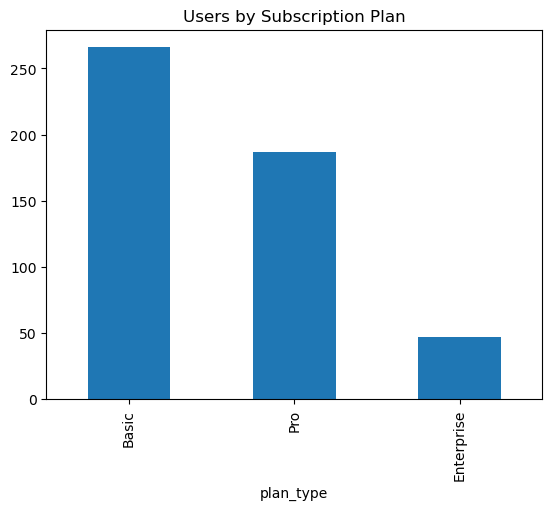

In [18]:
import matplotlib.pyplot as plt

df['plan_type'].value_counts().plot(kind='bar')
plt.title("Users by Subscription Plan")
plt.show()


In [21]:
""" CREATE DATABASE FROM PYTHON"""
import sqlite3

conn = sqlite3.connect("sql/saas.db")
df.to_sql("saas_users", conn, if_exists="replace", index=False)
conn.close()


# ADVANCED ANALYSIS

In [19]:
""" STEP 1: KPI CREATION """
total_users = df.shape[0]
total_revenue = df['monthly_revenue'].sum()
arpu = total_revenue / total_users
advanced_feature_rate = df['advanced_feature_used'].mean() * 100

total_users, total_revenue, arpu, advanced_feature_rate


(500, np.int64(19370), np.float64(38.74), np.float64(46.800000000000004))

In [20]:
""" STEP 2: USER SEGMENTATION """
def user_segment(row):
    if row['plan_type'] == 'Basic' and row['feature_usage_score'] > 70:
        return 'High Usage – Upsell Target'
    elif row['feature_usage_score'] > 70:
        return 'Power User'
    elif row['active_days'] < 90:
        return 'Low Engagement'
    else:
        return 'Regular User'

df['user_segment'] = df.apply(user_segment, axis=1)


In [21]:
df['user_segment'].value_counts()


user_segment
Regular User                  277
High Usage – Upsell Target     91
Power User                     79
Low Engagement                 53
Name: count, dtype: int64

In [22]:
""" STEP 3: FUNNEL ANALYSIS  
Signup → Active → Advanced Feature → Upsell """
funnel = {
    'Total Users': df.shape[0],
    'Active Users (>30 days)': df[df['active_days'] > 30].shape[0],
    'Advanced Feature Users': df[df['advanced_feature_used'] == 1].shape[0],
    'Upsell Targets': df[df['upgrade_likelihood'] == 1].shape[0]
}

funnel
""" I performed funnel analysis to understand drop-offs from usage to upsell.” """

' I performed funnel analysis to understand drop-offs from usage to upsell.” '

In [24]:
""" STEP 4: COHORT ANALYSIS """
df['signup_month'] = df['signup_date'].dt.to_period('M')

cohort = df.groupby('signup_month').agg(
    users=('user_id', 'count'),
    avg_revenue=('monthly_revenue', 'mean'),
    avg_feature_usage=('feature_usage_score', 'mean')
).reset_index()

cohort
""" I used cohort analysis to compare user value across signup periods""" 

' I used cohort analysis to compare user value across signup periods'

<Axes: title={'center': 'Avg Revenue by Signup Cohort'}, xlabel='signup_month'>

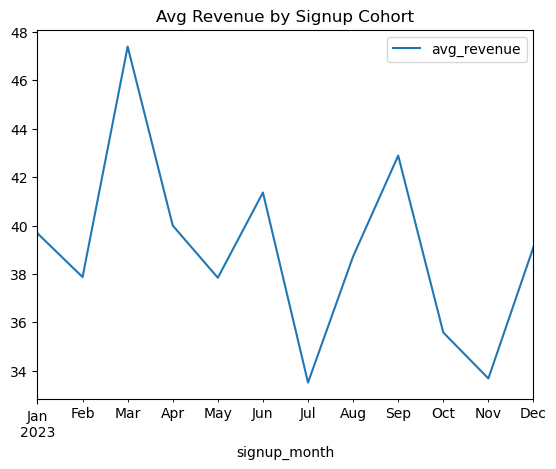

In [25]:
cohort.plot(x='signup_month', y='avg_revenue', kind='line', title='Avg Revenue by Signup Cohort')


In [26]:
""" STEP 5: DATA VALIDATION """
assert df['monthly_revenue'].min() > 0
assert df['feature_usage_score'].between(0,100).all()


# K-Means + Anomaly Detection

You are doing TWO-LAYER ANALYSIS 👇

🔹 Layer 1 — K-Means (Segmentation)

“What types of users do we have?”

🔹 Layer 2 — Anomaly Detection (Outliers)

“Within those users, who behaves unusually?”

In [27]:
""" STEP 1️⃣ Feature selection """
features = ['feature_usage_score', 'active_days', 'monthly_revenue']
X = df[features]


In [28]:
""" STEP 2️⃣ Scale data """
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "2"


In [29]:
""" STEP 3️⃣ K-Means → USER SEGMENTS """
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)


In [30]:
""" STEP 4️⃣ Understand clusters 
Example interpretation:

Cluster 0 → Low usage, low revenue

Cluster 1 → High usage, medium revenue 🔥

Cluster 2 → High revenue, enterprise-like users


"""
df.groupby('cluster')[features].mean()


,feature_usage_score,active_days,monthly_revenue
cluster,,,
0,56.912500,124.808333,31.500000
1,53.851064,214.659574,100.000000
2,56.272300,302.502347,33.380282


In [34]:
""" STEP 5️⃣ Apply Anomaly Detection """

df['anomaly'] = 1

for c in df['cluster'].unique():
    cluster_data = df[df['cluster'] == c][features]
    scaled_cluster = scaler.fit_transform(cluster_data)

    iso = IsolationForest(contamination=0.05, random_state=42)
    df.loc[df['cluster'] == c, 'anomaly'] = iso.fit_predict(scaled_cluster)


In [36]:
cluster_labels = {
    0: "Low Engagement Users",
    1: "Enterprise High-Engagement Users",
    2: "High Usage Upsell Candidates"
}

df['cluster_label'] = df['cluster'].map(cluster_labels)


In [37]:
""" STEP 6️⃣ Business interpretation """
df[(df['cluster'] == 1) & (df['anomaly'] == -1)]


,user_id,signup_date,last_login_date,plan_type,monthly_fee,active_days,feature_usage_score,advanced_feature_used,monthly_revenue,upgrade_likelihood,user_segment,signup_month,cluster,anomaly,cluster_label
136,U0137,2023-02-11,2024-02-12,Enterprise,100,366,11,0,100,0,Regular User,2023-02,1,-1,Enterprise High-Engagement Users
269,U0270,2023-01-09,2024-02-23,Enterprise,100,410,44,0,100,0,Regular User,2023-01,1,-1,Enterprise High-Engagement Users
310,U0311,2023-02-07,2024-02-28,Enterprise,100,386,91,1,100,0,Power User,2023-02,1,-1,Enterprise High-Engagement Users


# K-Means helped me identify user segments, and Isolation Forest highlighted unusual users within each segment who may need personalized upsell or account management.

In [39]:
""" CSV FOR POWERBI"""
df.to_csv("saas_users_ml_output.csv", index=False)


# Machine Learning Conclusion

In this project, I applied unsupervised learning techniques to analyze SaaS user behavior. 
K-Means clustering was used to segment users based on engagement, feature usage, and revenue patterns.
This helped identify distinct user groups such as low engagement users, high-usage upsell candidates, 
and enterprise-level high-engagement customers.

To further refine insights, Isolation Forest was applied within each cluster to detect anomalous users.
These anomalies represent power users or unusual behavior patterns that may require personalized 
upsell strategies or account management.

Instead of relying on complex predictive models, this approach focuses on interpretability 
and business impact, making the results directly actionable for marketing and sales teams.
